# Installing Dependencies

In [35]:
                            !pip install -q https://storage.googleapis.com/tensorflow/linux/cpu/tensorflow-2.11.0-cp37-cp37m-linux_x86_64.whl


ERROR: Could not install packages due to an OSError: HTTPSConnectionPool(host='storage.googleapis.com', port=443): Max retries exceeded with url: /tensorflow/linux/cpu/tensorflow-2.11.0-cp37-cp37m-linux_x86_64.whl (Caused by NewConnectionError('<pip._vendor.urllib3.connection.HTTPSConnection object at 0x7e6dcdc577d0>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution'))



In [36]:
!pip install -q tensorflow-io

In [37]:
! pip install -q -U tensorflow-io transformers librosa tensorflow==2.11.0 tf2onnx keras2onnx onnxruntime

ERROR: Could not find a version that satisfies the requirement tf2onnx (from versions: none)
ERROR: No matching distribution found for tf2onnx


# importing Dependencies

In [76]:
import warnings
import pandas as pd 
warnings.filterwarnings('ignore')
import os
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import numpy as np
import librosa
device_name = tf.test.gpu_device_name()
device_name
import keras
from IPython import display
#import tf2onnx
#import onnx
#import onnxruntime as ort
print ('listo')

listo


# Set up file location

In [39]:
for i in os.listdir('/kaggle/input/audio-data/voices_dataset'):
  print(i)

Andres Cabral
David Mayorga
Fernando Meneses


In [40]:
audio_path = '/kaggle/input/audio-data/voices_dataset'
print('listo')

listo


# Set up Hyper parameters 

Here num_classes are number of speakers.

Num_samples = 80000 is sample rate, as audios length are 5s so sample rate for 5s is 80000.

I kept Batch_size is 32, and learning_rate = 0.001

In [41]:
num_classes = 4
num_samples = 80000
num_mel_bins = 128
fft_length = 2048
hop_length = 512
batch_size = 32
learning_rate = 0.001
print('listo')

listo


# Make a list data with labels

In [42]:

audio_files = []
labels = []

labelind = -1
for label in os.listdir(audio_path):
    labelind +=1
    label_path = os.path.join(audio_path, label)
    for audio_file in os.listdir(label_path):
        audio_file_path = os.path.join(label_path, audio_file)
        audio_files.append(audio_file_path)
        labels.append(labelind)
        
print('listo')

listo


# Preprocess audio file into numeric form

In [43]:

def preprocess_audio(audio_file_path):
    audio, sr = librosa.load(audio_file_path, sr=num_samples)
    if len(audio) > num_samples:
        audio = audio[:num_samples]
    else:
        audio = np.pad(audio, (0, num_samples - len(audio)), 'constant')
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=fft_length, hop_length=hop_length, n_mels=num_mel_bins)
    mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
    return abs(mel_spec_db)

audio_data = []

for audio_file in audio_files:
    mel_spec_db = preprocess_audio(audio_file)
    audio_data.append(mel_spec_db)

audio_data = np.array(audio_data)
labels = np.array(labels)

print('listo')

listo


# Spliting main data into Train and Test data

In [44]:

num_examples = len(audio_files)
num_train_examples = int(num_examples * 0.8)
num_val_examples = num_examples - num_train_examples

train_indices = np.random.choice(num_examples, num_train_examples, replace=False)
val_indices = np.array(list(set(range(num_examples)) - set(train_indices)))

train_data = audio_data[train_indices]
train_labels = labels[train_indices]

val_data = audio_data[val_indices]
val_labels = labels[val_indices]

print('listo')

listo


In [45]:
# Create TensorFlow datasets for the training and validation sets
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=num_train_examples)
train_dataset =train_dataset.batch(batch_size=batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels))
val_dataset = val_dataset.batch(batch_size=batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

print('listo')

listo


# Simple Model

In [46]:


model2 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(128, 157, 1)), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(32, (3, 3)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),
    
    # tercer bloque de convolución
    tf.keras.layers.Conv2D(128, (3, 3)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)), 
    tf.keras.layers.Dropout(0.2),
    
    # cuarto bloque de convolución
    tf.keras.layers.Conv2D(256, (3, 3)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),
        
    
    
    # agrupamento global ao invés de função de nivelamento
    tf.keras.layers.GlobalAveragePooling2D(), 
    
    # bloco denso
    tf.keras.layers.Dense(256, activation='relu'),  
    tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(64, activation='relu'),   
#     tf.keras.layers.Dropout(0.5),
    
    # camada de classificação
    tf.keras.layers.Dense(11, activation='softmax')
])

print('listo')

listo


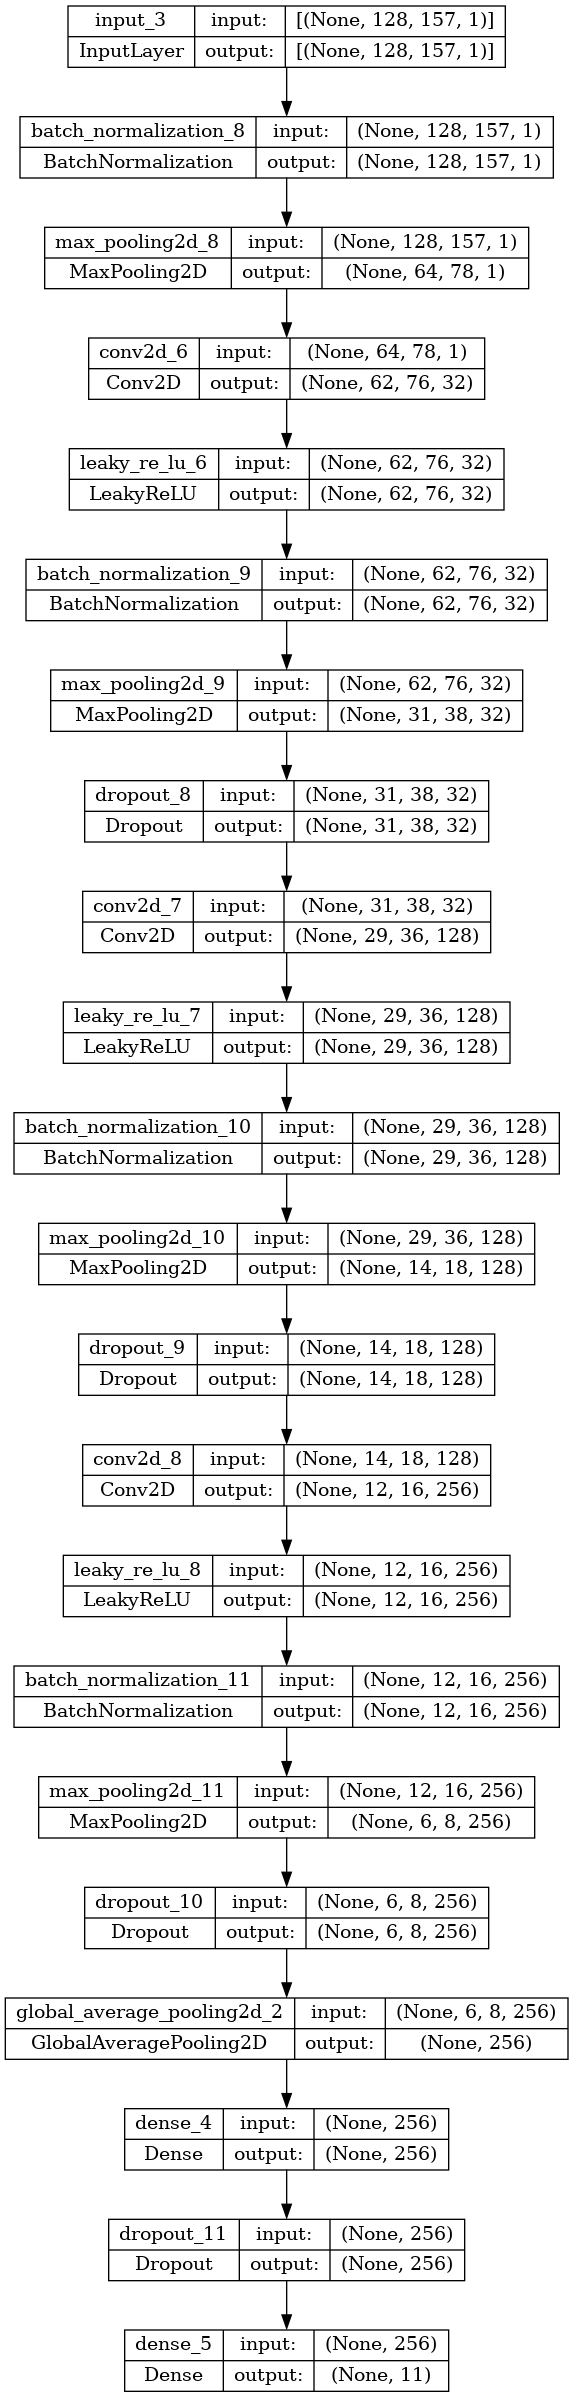

In [47]:

from keras.utils.vis_utils import plot_model
plot_model(model2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Creating Callbacks for save the best trained model.

In [48]:
call_back = [tf.keras.callbacks.ModelCheckpoint(filepath='best_model_vgg.h5', 
                                                monitor='val_accuracy',
                                                mode='max',
                                                verbose=1,
                                                save_best_only=True)]

In [49]:
# Compile the model
model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',tf.keras.metrics.SparseCategoricalAccuracy()],
            
)
print('listo')

listo


In [50]:
hist = model2.fit(train_dataset, epochs=10, validation_data=val_dataset,callbacks=call_back,)

Epoch 1/10


2023-11-08 06:59:31.627436: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


25/27 [==========================>...] - ETA: 0s - loss: 1.1661 - accuracy: 0.4988 - sparse_categorical_accuracy: 0.4988
Epoch 1: val_accuracy improved from -inf to 0.35484, saving model to best_model_vgg.h5
27/27 [==============================] - 4s 26ms/step - loss: 1.1389 - accuracy: 0.5139 - sparse_categorical_accuracy: 0.5139 - val_loss: 3.7451 - val_accuracy: 0.3548 - val_sparse_categorical_accuracy: 0.3548
Epoch 2/10
23/27 [========================>.....] - ETA: 0s - loss: 0.7099 - accuracy: 0.7092 - sparse_categorical_accuracy: 0.7092
Epoch 2: val_accuracy improved from 0.35484 to 0.37788, saving model to best_model_vgg.h5
27/27 [==============================] - 0s 16ms/step - loss: 0.6804 - accuracy: 0.7257 - sparse_categorical_accuracy: 0.7257 - val_loss: 2.3965 - val_accuracy: 0.3779 - val_sparse_categorical_accuracy: 0.3779
Epoch 3/10
27/27 [==============================] - ETA: 0s - loss: 0.4640 - accuracy: 0.8275 - sparse_categorical_accuracy: 0.8275
Epoch 3: val_accur

dict_keys(['loss', 'accuracy', 'sparse_categorical_accuracy', 'val_loss', 'val_accuracy', 'val_sparse_categorical_accuracy'])


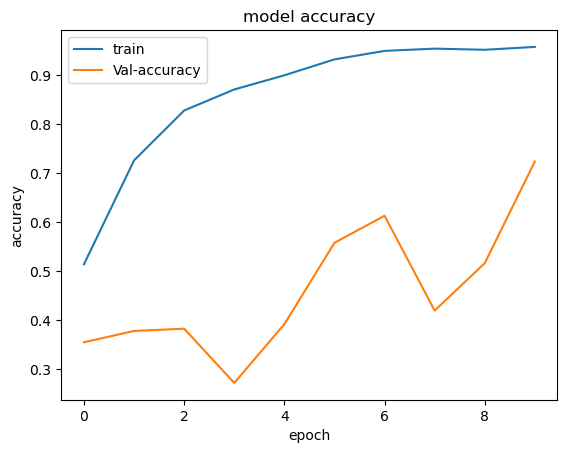

In [69]:
print(hist.history.keys())
# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
# plt.plot(hist.history['sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Val-accuracy'], loc='upper left')
plt.show()

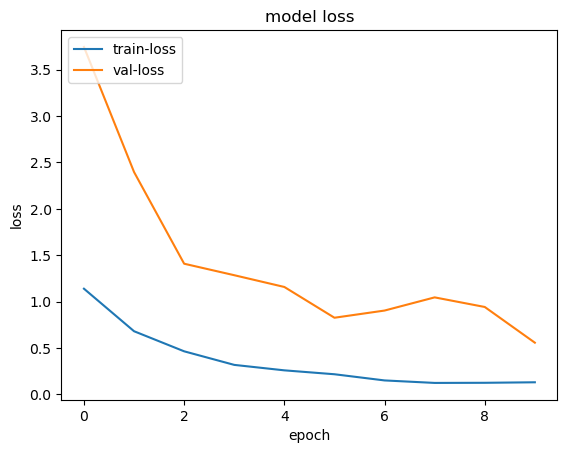

In [52]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train-loss', 'val-loss'], loc='upper left')
plt.show()

In [53]:
features, labels = val_dataset.as_numpy_iterator().next()

In [54]:
features[0]

array([[52.7712  , 58.56987 , 80.      , ..., 54.02584 , 45.00147 ,
        23.64226 ],
       [46.995026, 39.12422 , 45.08898 , ..., 17.013018, 12.687477,
        14.899345],
       [44.046204, 31.980011, 32.981815, ...,  8.940546,  6.879982,
        13.154831],
       ...,
       [80.      , 80.      , 80.      , ..., 80.      , 80.      ,
        80.      ],
       [80.      , 80.      , 80.      , ..., 80.      , 80.      ,
        80.      ],
       [80.      , 80.      , 80.      , ..., 80.      , 80.      ,
        80.      ]], dtype=float32)

In [55]:
labels

array([1, 2, 1, 0, 1, 1, 1, 2, 0, 0, 1, 0, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1,
       0, 2, 1, 0, 0, 0, 1, 0, 0, 1])

In [56]:
y_pred = model2.predict(features)

1/1 [==============================] - 0s 123ms/step


In [57]:
pred = []

In [58]:
for i in y_pred:
    pred.append(i.argmax())

In [92]:
print(np.array(labels),'\n',np.array(pred))

[1 2 1 0 1 1 1 2 0 0 1 0 2 2 1 2 2 1 2 1 1 1 0 2 1 0 0 0 1 0 0 1] 
 [1 1 0 0 1 1 1 0 0 0 1 0 2 2 0 2 2 1 2 1 1 0 0 2 1 0 0 0 1 0 0 1]


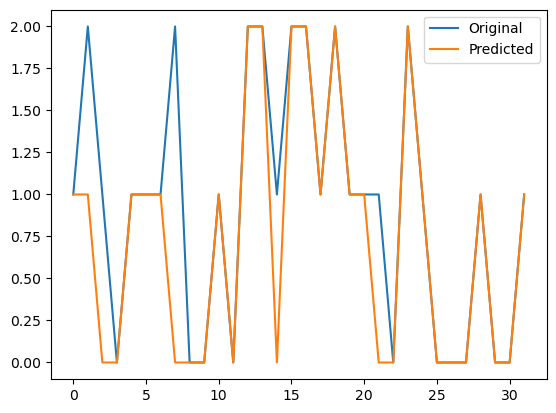

In [60]:
plt.plot(np.array(labels),label = 'Original')
plt.plot(np.array(pred), label = 'Predicted')
plt.legend()
plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape

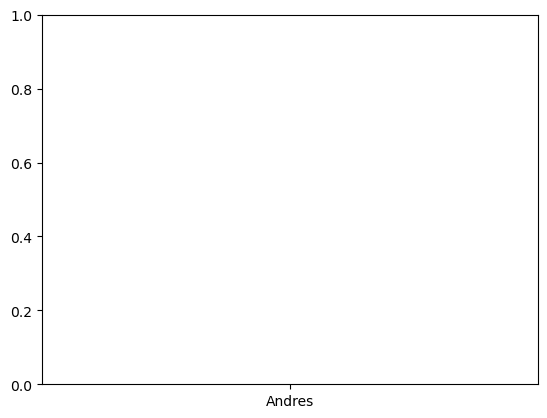

In [104]:
# Define the functions to preprocess audio data
def get_spectrogram(audio):
    num_samples = 220500  # Adjust to your desired number of samples
    fft_length = 2048
    hop_length = 512
    num_mel_bins = 128
    sr = 44100  # Sample rate
    audio = tf.squeeze(audio, axis=-1)
    
    # You can reuse your existing preprocessing code here
    
    return mel_spec_db

# Load your trained speaker classification model
model = model2

# Path to the audio file you want to classify
audio_path = '/kaggle/input/audio-data/voices_dataset/David Mayorga/output_segment_101.wav'

# Read and preprocess the audio file
x = tf.io.read_file(audio_path)
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=num_samples)
x = get_spectrogram(x)
x = x[tf.newaxis, ...]

# Perform speaker classification
prediction = model(x)

# Define class labels (adjust as needed)
x_labels = ['Andres', 'David', 'Fernando']

# Visualize the prediction as a bar chart
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Speaker Classification')
plt.show()

# Play the audio
display.display(display.Audio(x, rate=sample_rate))